In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer
from scipy import stats

In [2]:
# load data
customer_df = pd.read_csv('data/twm_customer.csv', sep = ';')
accounts_df = pd.read_csv('data/twm_accounts.csv', sep = ';')
transactions_df = pd.read_csv('data/twm_transactions.csv', sep = ';')

In [3]:
# join tables
merged_df = customer_df.merge(accounts_df, on='cust_id').merge(transactions_df, on='acct_nbr')
merged_df.head(1)

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,...,ending_balance,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,...,1548.23,13,-16.64,-16.64,0.0,-850.55,26.10.1995,120742,E,CG


In [4]:
# select and explore relevant cols
relevant_cols = ['cust_id', 'acct_nbr', 'tran_id', 'tran_amt', 'acct_type', 'account_active', 'interest_amt', 'tran_code']
relevant_df = merged_df[relevant_cols]
print(relevant_df.head(1), '\n')
relevant_df.info()
relevant_df.iloc[:, 3:].describe()

   cust_id          acct_nbr  tran_id  tran_amt acct_type account_active  \
0  1362487  4561143213624870       13    -16.64      CC               Y    

   interest_amt tran_code  
0           0.0      CG     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77560 entries, 0 to 77559
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cust_id         77560 non-null  int64  
 1   acct_nbr        77560 non-null  int64  
 2   tran_id         77560 non-null  int64  
 3   tran_amt        77560 non-null  float64
 4   acct_type       77560 non-null  object 
 5   account_active  77560 non-null  object 
 6   interest_amt    77560 non-null  float64
 7   tran_code       77560 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 5.3+ MB


,tran_amt,interest_amt
count,77560.000000,77560.000000
mean,-7.863734,0.762981
std,312.190641,4.427613
min,-3312.410000,0.000000
25%,-100.000000,0.000000
50%,-1.905000,0.000000
75%,0.170000,0.000000
max,17464.520000,164.520000


Axes(0.125,0.11;0.775x0.77)


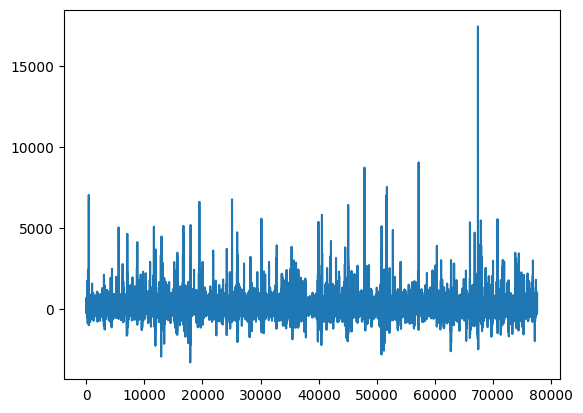

In [5]:
print(relevant_df['tran_amt'].plot()) # def an outlier or two here

Axes(0.125,0.11;0.775x0.77)


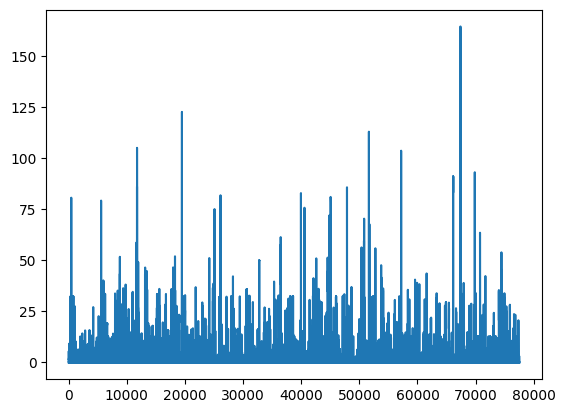

In [6]:
print(relevant_df['interest_amt'].plot()) # some outliers here too

In [7]:
#filter outliers
def remove_column_outliers(df, column, threshold):
    print(f"The variation in {column} was {df[column].var()} before filtering outliers.")

    mean = df[column].mean()
    std_dev = df[column].std()
    threshold = 3
    outliers = (df[column] - mean).abs() > threshold * std_dev

    prev_len = len(df)
    df_filtered = df[~outliers]

    print(f"The variation in {column} is {df_filtered[column][~outliers].var()} after removing the {prev_len - len(df_filtered)} values outside of {threshold} standard deviations from the mean.")
    df_filtered[column].plot()
    
    
    return df_filtered

The variation in tran_amt was 97462.99604411147 before filtering outliers.
The variation in tran_amt is 37995.65868097996 after removing the 1355 values outside of 3 standard deviations from the mean.


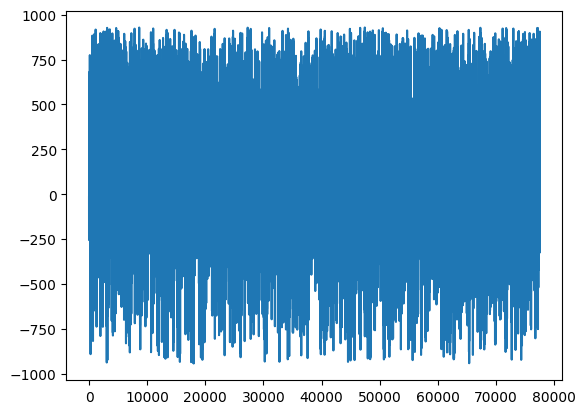

In [8]:
relevant_df = remove_column_outliers(relevant_df, 'tran_amt', 3)

The variation in interest_amt was 14.064237699841954 before filtering outliers.
The variation in interest_amt is 1.1882763213552086 after removing the 1228 values outside of 3 standard deviations from the mean.


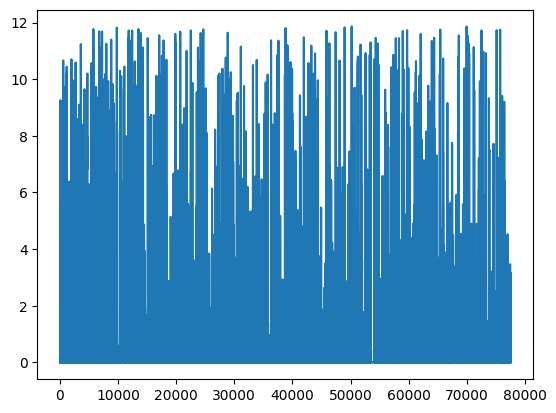

In [9]:
relevant_df = remove_column_outliers(relevant_df, 'interest_amt', 3)

<Axes: >

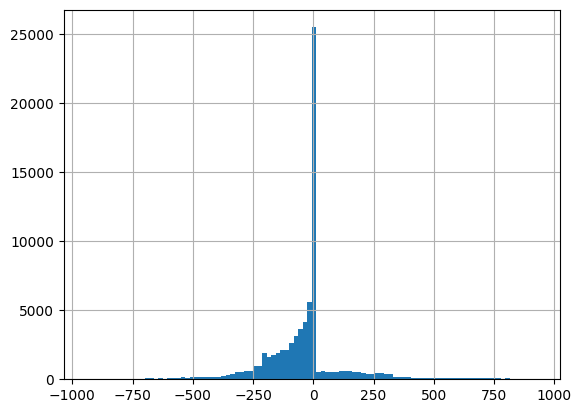

In [10]:
relevant_df['tran_amt'].hist(bins = 100) # doesn't look great

There are abundant transactions of $0.00 that are marked as type IQ. IQ may mean "Identitiy Questioned" which would make those transactions for the purpose of identity confirmation. Regardless, they are not going to be valuable in the model, so they need to go.

In [11]:
print(relevant_df['tran_code'].value_counts())

WD      17953
CG      12402
IQ      10886
DP       8943
IN       6427
FK       6028
TR       5054
PM       2596
CA       1590
FU       1498
FP       1494
FM         73
FA         33
Name: tran_code, dtype: int64


<Axes: >

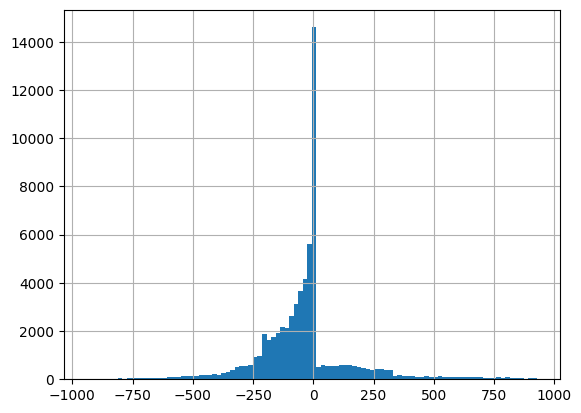

In [12]:
# Remove IQ transactions
relevant_df = relevant_df[relevant_df['tran_code'] != 'IQ  ']
relevant_df['tran_amt'].hist(bins = 100) # better

In [13]:
# engineer features
avg_tran_amt = relevant_df[['tran_amt', 'cust_id']].groupby(['cust_id']).mean()
avg_interest_paid = relevant_df[['interest_amt', 'cust_id']][relevant_df['tran_code'] == 'PM  '].groupby(['cust_id']).mean()
avg_interest_earned = relevant_df[['interest_amt', 'cust_id']][relevant_df['tran_code'] == 'IN  '].groupby(['cust_id']).mean()

features = pd.DataFrame({'avg_tran_amt': avg_tran_amt['tran_amt'],'avg_interest_paid': avg_interest_paid['interest_amt'], 'avg_interest_earned':avg_interest_earned['interest_amt']})
features = features.fillna(0)
features

,avg_tran_amt,avg_interest_paid,avg_interest_earned
cust_id,,,
1362480,-36.907395,0.0000,1.418333
1362484,-11.352882,0.0000,1.218000
1362485,-19.291400,3.4160,0.000000
1362486,-23.582128,0.0000,2.383333
1362487,-39.045275,3.4075,1.973158
...,...,...,...
1363490,2.853333,0.0000,2.853333
1363491,-11.037059,0.0000,0.420000
1363492,-110.589293,0.0000,1.200833


<Axes: >

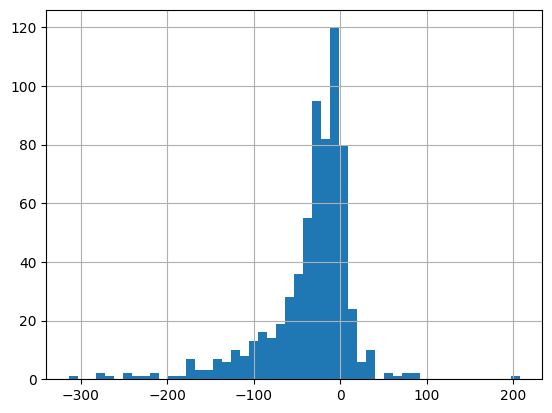

In [14]:
features['avg_tran_amt'].hist(bins=50)

<Axes: >

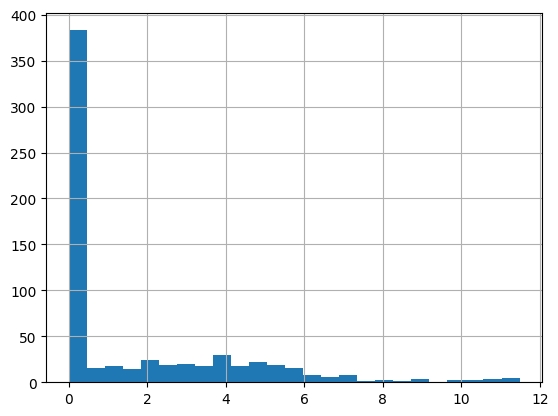

In [15]:
features['avg_interest_paid'].hist(bins = 25) # needs transformation

<Axes: >

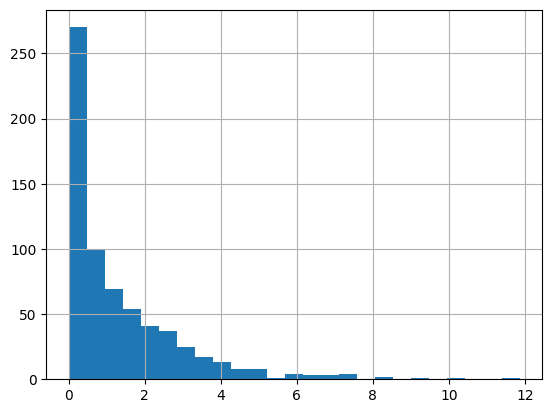

In [16]:
features['avg_interest_earned'].hist(bins = 25) # also needs transformation

<Axes: >

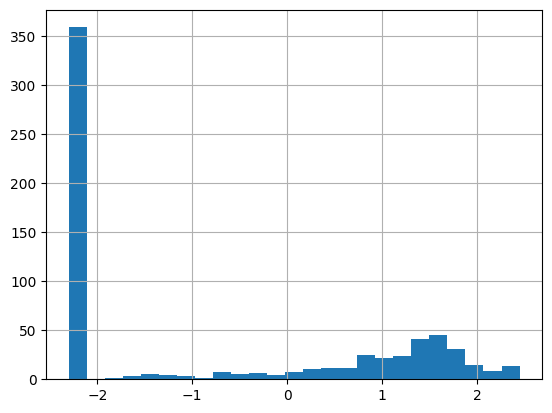

In [17]:
# transform interest_paid
features['avg_interest_paid'] = features['avg_interest_paid'].apply(lambda a : np.log(a + 0.1))
features['avg_interest_paid'].hist(bins = 25)

<Axes: >

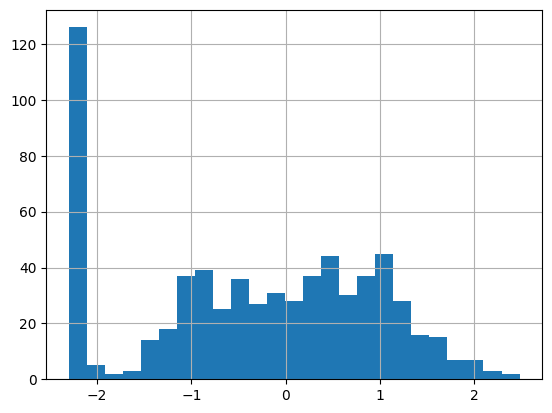

In [18]:
# transform interest_earned
features['avg_interest_earned'] = features['avg_interest_earned'].apply(lambda a : np.log(a + 0.1))
features['avg_interest_earned'].hist(bins = 25)

In [19]:
# scale features
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(features)
feature_names = scaler.feature_names_in_

In [20]:
# One-hot encoding for acct_type

encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(relevant_df[['acct_type']])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns = ['acct_type_CC', 'acct_type_CK', 'acct_type_SV'])
encoded_id_df = pd.concat([relevant_df['cust_id'], encoded_df], axis=1)

In [21]:
#Combine encoded with scaled features
X_with_id = pd.concat([pd.DataFrame(scaled_feats), encoded_id_df.groupby('cust_id').max().fillna(0).reset_index()], axis = 1)
for i, name in enumerate(feature_names):
    X_with_id = X_with_id.rename(columns = {i:name})
X = X_with_id.drop('cust_id', axis = 1)

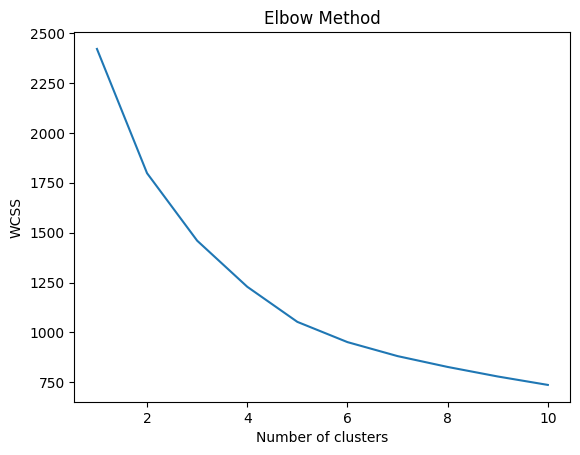

In [22]:
#determine optimal number of clusters

# elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init = 10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() #looks like 2, maybe 3

In [23]:
# apply K-means algorithm
k = 3 #number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
kmeans.fit(X)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(X)

Explained variance ratio: [0.28367724 0.27731536 0.26617814]


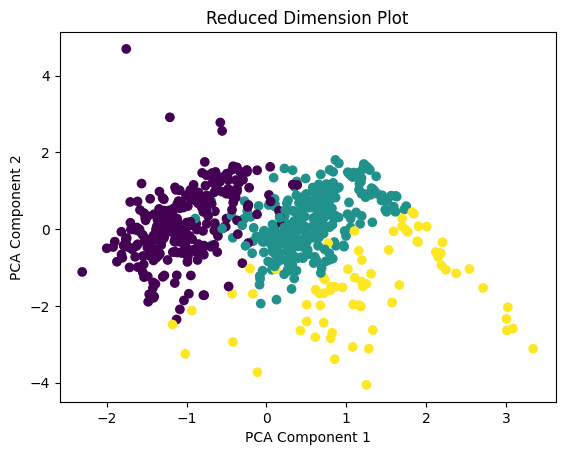

In [24]:
# visualize clusters
from sklearn.decomposition import PCA

#intantiate_pca_object
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(X)

#Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot data in reduced dimensions
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_kmeans)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Reduced Dimension Plot")
plt.show()

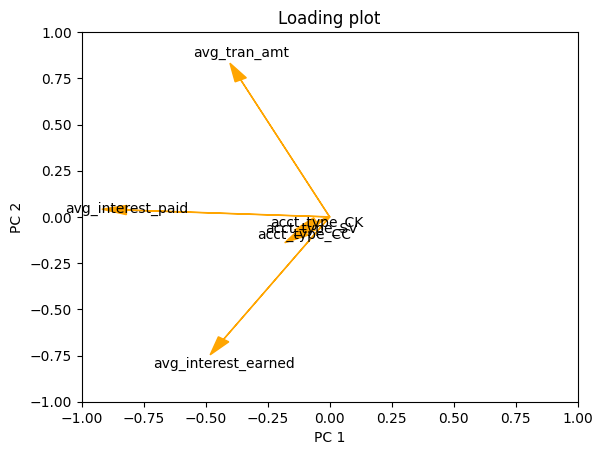

In [25]:
#Add a loading plot
fig, ax = plt.subplots()

#Plot arrows representing feature loadings
for i, feature in enumerate(X):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.05, head_length=0.1, color="orange")
    ax.text(pca.components_[0,i], pca.components_[1, i]*1.2, feature, ha='center', va='center', color='black')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('Loading plot')

plt.show()

In [26]:
#Check silhouette score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette avg:", silhouette_avg)

Silhouette avg: 0.2954286395725628


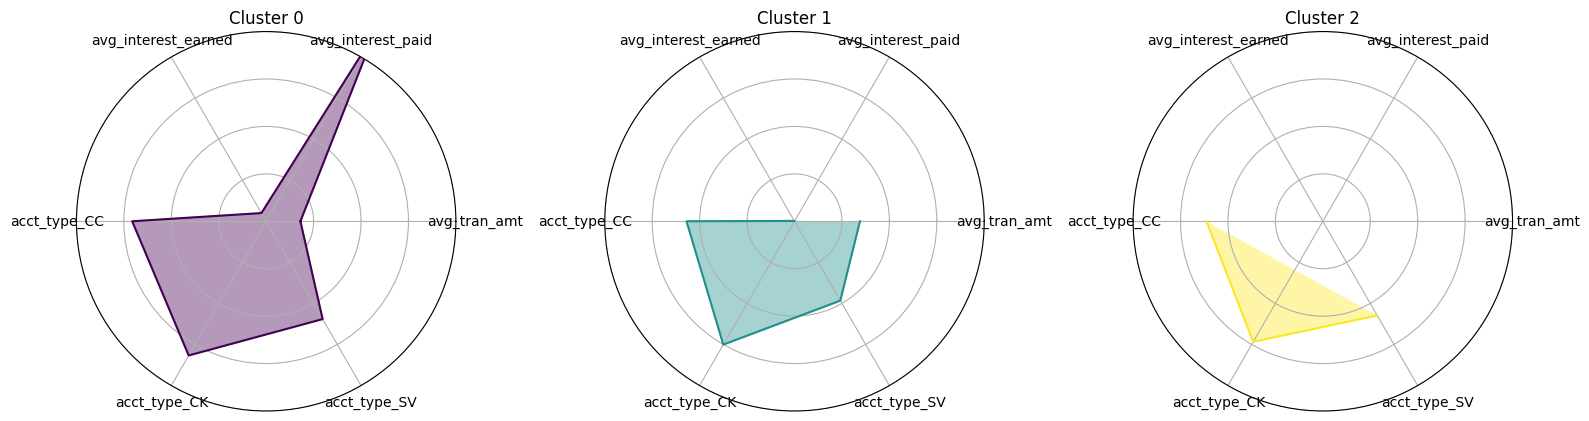

In [27]:
# Visualize cluster features

kmeans.fit(X)
labels = kmeans.labels_

#set some colors for visualizations
viridis = ['#440154', '#21908C', '#FDE725', '#2C5F2D', '#FFEDA0']

# Assign cluster labels to the original data
data_with_labels = pd.concat([pd.DataFrame(X), pd.DataFrame(labels, columns=['cluster'])], axis=1)

# Compute the mean of each cluster for each feature
cluster_means = data_with_labels.groupby('cluster').mean()

# Create a series of radar charts
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(16, 6), subplot_kw=dict(projection='polar'))

# Set the number of radial gridlines to 5 for each polar subplot
for ax in axs:
    ax.set_rgrids(np.linspace(0, 1, num=5))
    ax.set_ylim([0, 1])

for i, ax in enumerate(axs):
    # Calculate the angle for each variable
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Plot the normalized mean for the i-th cluster
    values = np.concatenate((cluster_means.iloc[i].values.flatten().tolist(), [cluster_means.iloc[i][0]]))
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', color = viridis[i])
    ax.fill(angles, values, alpha=0.4, color = viridis[i])
    
    # Set the title and labels
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cluster_means.columns, ha='center', fontsize=10)
    ax.set_yticklabels([])
    
# Add a legend
labels = ['Feature {}'.format(i) for i in range(1, len(cluster_means.columns)+1)]

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [43]:
# Assign cluster labels to the customers traits (StandardScaler)

kmeans.fit(X)
labels = kmeans.labels_

data_with_labels = pd.concat([pd.DataFrame(X_with_id), pd.DataFrame(labels, columns=['cluster'])], axis=1)
merged_with_labels = (pd.merge(pd.read_csv('data/twm_customer.csv', sep = ';')[['income', 'age', 'years_with_bank', 'nbr_children', 'cust_id']], data_with_labels[['cluster', 'cust_id']], on='cust_id')).drop('cust_id', axis = 1)

# scale traits
traits_scalePrep = merged_with_labels[['income', 'age', 'years_with_bank', 'nbr_children']]

scaler = StandardScaler()
scaled_traits = scaler.fit_transform(traits_scalePrep)
feature_names = scaler.feature_names_in_

#Combine encoded with scaled features
traits_with_labels = pd.concat([pd.DataFrame(scaled_traits), merged_with_labels['cluster']], axis = 1)
for i, name in enumerate(feature_names):
    traits_with_labels = traits_with_labels.rename(columns = {i:name})
traits_with_labels


,income,age,years_with_bank,nbr_children,cluster
0,-0.741461,1.504050,-1.063034,-0.642769,0
1,-0.203856,-0.247415,1.537863,-0.642769,0
2,1.106957,0.601780,-0.319920,-0.642769,1
3,0.966783,0.867154,1.909419,1.183467,1
4,-1.038780,-1.415058,-1.063034,-0.642769,0
...,...,...,...,...,...
657,-0.372795,-0.353564,0.794749,0.270349,1
658,0.149010,0.707930,0.794749,0.270349,1
659,1.720591,0.389482,-1.434590,1.183467,2
660,-0.359065,-0.300489,1.166306,-0.642769,1


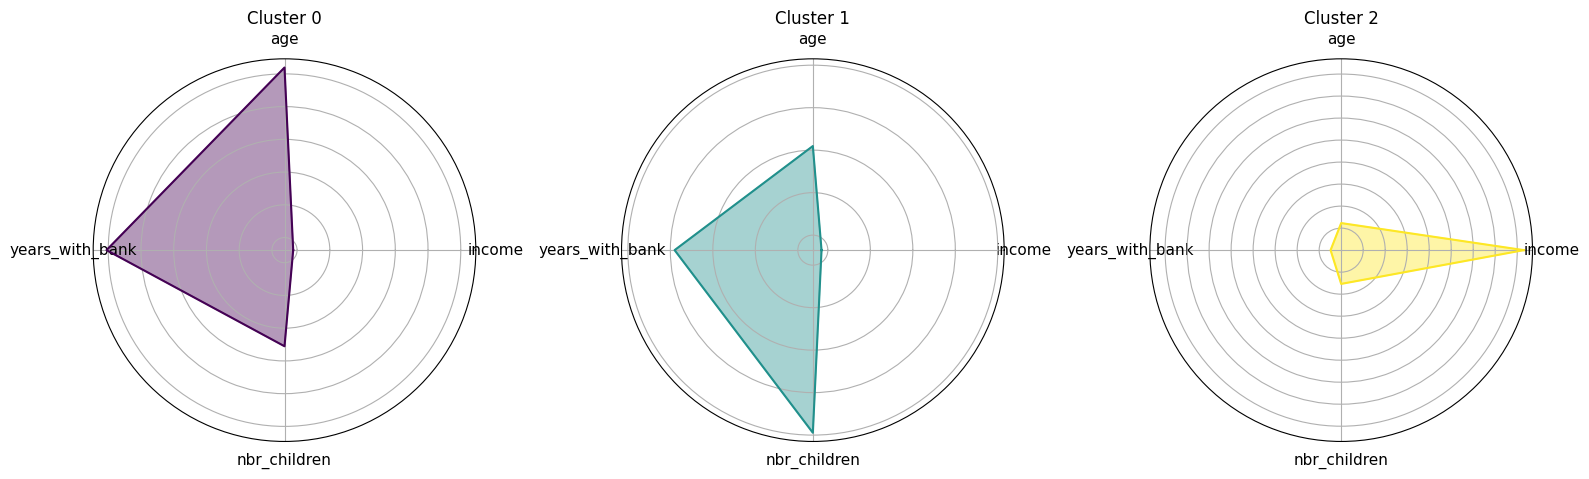

In [45]:
#Visualize demographic info of clusters

#set some colors for visualizations
viridis = ['#440154', '#21908C', '#FDE725']

# Compute the mean of each cluster for each feature
cluster_means = traits_with_labels.groupby('cluster').mean()

# Create a series of radar charts
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(16, 6), subplot_kw=dict(projection='polar'))
for i, ax in enumerate(axs):
    # Calculate the angle for each variable
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Plot the normalized mean for the i-th cluster
    values = np.concatenate((cluster_means.iloc[i].values.flatten().tolist(), [cluster_means.iloc[i][0]]))
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', color = viridis[i])
    ax.fill(angles, values, alpha=0.4, color = viridis[i])
    
    # Set the title and labels
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cluster_means.columns, ha='center', fontsize=11)
    ax.set_yticklabels([])
    
# Add a legend
labels = ['Feature {}'.format(i) for i in range(1, len(cluster_means.columns)+1)]

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [46]:
# Assign cluster labels to the customers traits (Normalizer L1)

kmeans.fit(X)
labels = kmeans.labels_

data_with_labels = pd.concat([pd.DataFrame(X_with_id), pd.DataFrame(labels, columns=['cluster'])], axis=1)
merged_with_labels = (pd.merge(pd.read_csv('data/twm_customer.csv', sep = ';')[['income', 'age', 'years_with_bank', 'nbr_children', 'cust_id']], data_with_labels[['cluster', 'cust_id']], on='cust_id')).drop('cust_id', axis = 1)

# scale traits
traits_scalePrep = merged_with_labels[['income', 'age', 'years_with_bank', 'nbr_children']]

scaler = Normalizer(norm='l1')
scaled_traits = scaler.fit_transform(traits_scalePrep)
feature_names = scaler.feature_names_in_

#Combine encoded with scaled features
traits_with_labels = pd.concat([pd.DataFrame(scaled_traits), merged_with_labels['cluster']], axis = 1)
for i, name in enumerate(feature_names):
    traits_with_labels = traits_with_labels.rename(columns = {i:name})
traits_with_labels


,income,age,years_with_bank,nbr_children,cluster
0,0.989217,0.010634,0.000150,0.000000,0
1,0.997526,0.002044,0.000430,0.000000,0
2,0.998806,0.001131,0.000063,0.000000,1
3,0.998431,0.001322,0.000202,0.000045,1
4,0.000000,0.941176,0.058824,0.000000,0
...,...,...,...,...,...
657,0.997102,0.002426,0.000404,0.000067,1
658,0.997618,0.002117,0.000227,0.000038,1
659,0.999152,0.000815,0.000000,0.000033,2
660,0.997095,0.002443,0.000462,0.000000,1


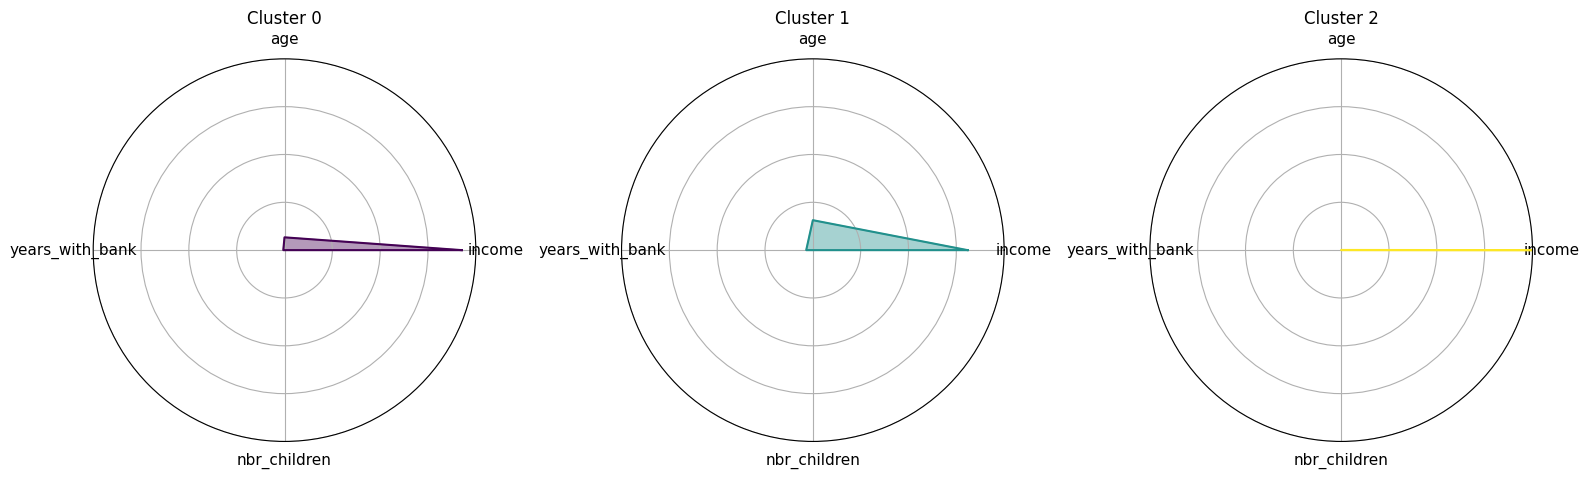

In [47]:
#Visualize demographic info of clusters

#set some colors for visualizations
viridis = ['#440154', '#21908C', '#FDE725']

# Compute the mean of each cluster for each feature
cluster_means = traits_with_labels.groupby('cluster').mean()

# Create a series of radar charts
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(16, 6), subplot_kw=dict(projection='polar'))

# Set the number of radial gridlines to 5 for each polar subplot
for ax in axs:
    ax.set_rgrids(np.linspace(0, 1, num=5))
    ax.set_ylim([0, 1])

for i, ax in enumerate(axs):
    # Calculate the angle for each variable
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Plot the normalized mean for the i-th cluster
    values = np.concatenate((cluster_means.iloc[i].values.flatten().tolist(), [cluster_means.iloc[i][0]]))
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', color = viridis[i])
    ax.fill(angles, values, alpha=0.4, color = viridis[i])
    
    # Set the title and labels
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cluster_means.columns, ha='center', fontsize=11)
    ax.set_yticklabels([])
    
# Add a legend
labels = ['Feature {}'.format(i) for i in range(1, len(cluster_means.columns)+1)]

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [48]:
# Assign cluster labels to the customers traits (Normalizer L2)

kmeans.fit(X)
labels = kmeans.labels_

data_with_labels = pd.concat([pd.DataFrame(X_with_id), pd.DataFrame(labels, columns=['cluster'])], axis=1)
merged_with_labels = (pd.merge(pd.read_csv('data/twm_customer.csv', sep = ';')[['income', 'age', 'years_with_bank', 'nbr_children', 'cust_id']], data_with_labels[['cluster', 'cust_id']], on='cust_id')).drop('cust_id', axis = 1)

# scale traits
traits_scalePrep = merged_with_labels[['income', 'age', 'years_with_bank', 'nbr_children']]

scaler = Normalizer(norm='l2')
scaled_traits = scaler.fit_transform(traits_scalePrep)
feature_names = scaler.feature_names_in_

#Combine encoded with scaled features
traits_with_labels = pd.concat([pd.DataFrame(scaled_traits), merged_with_labels['cluster']], axis = 1)
for i, name in enumerate(feature_names):
    traits_with_labels = traits_with_labels.rename(columns = {i:name})
traits_with_labels


,income,age,years_with_bank,nbr_children,cluster
0,0.999942,0.010749,0.000151,0.000000,0
1,0.999998,0.002049,0.000431,0.000000,0
2,0.999999,0.001133,0.000063,0.000000,1
3,0.999999,0.001324,0.000202,0.000045,1
4,0.000000,0.998053,0.062378,0.000000,0
...,...,...,...,...,...
657,0.999997,0.002433,0.000406,0.000068,1
658,0.999998,0.002122,0.000227,0.000038,1
659,1.000000,0.000816,0.000000,0.000033,2
660,0.999997,0.002450,0.000464,0.000000,1


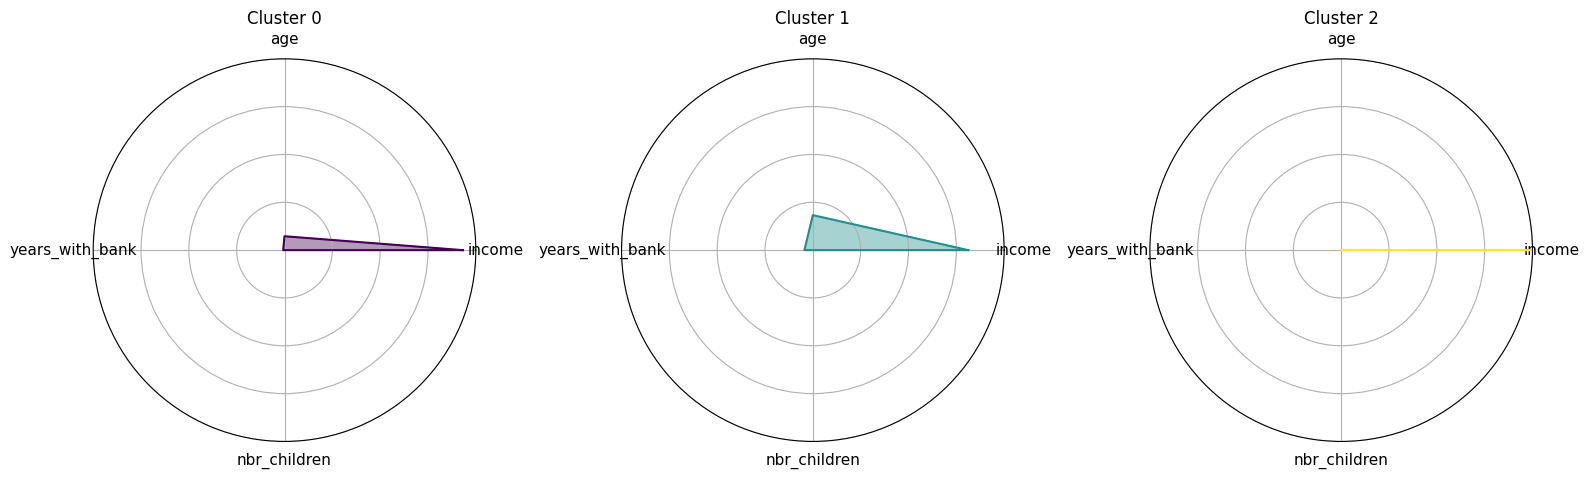

In [50]:
#Visualize demographic info of clusters

#set some colors for visualizations
viridis = ['#440154', '#21908C', '#FDE725']

# Compute the mean of each cluster for each feature
cluster_means = traits_with_labels.groupby('cluster').mean()

# Create a series of radar charts
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(16, 6), subplot_kw=dict(projection='polar'))

# Set the number of radial gridlines to 5 for each polar subplot
for ax in axs:
    ax.set_rgrids(np.linspace(0, 1, num=5))
    ax.set_ylim([0, 1])

for i, ax in enumerate(axs):
    # Calculate the angle for each variable
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Plot the normalized mean for the i-th cluster
    values = np.concatenate((cluster_means.iloc[i].values.flatten().tolist(), [cluster_means.iloc[i][0]]))
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', color = viridis[i])
    ax.fill(angles, values, alpha=0.4, color = viridis[i])
    
    # Set the title and labels
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cluster_means.columns, ha='center', fontsize=11)
    ax.set_yticklabels([])
    
# Add a legend
labels = ['Feature {}'.format(i) for i in range(1, len(cluster_means.columns)+1)]

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()

In [51]:
# Assign cluster labels to the customers traits (Min-Max)

kmeans.fit(X)
labels = kmeans.labels_

data_with_labels = pd.concat([pd.DataFrame(X_with_id), pd.DataFrame(labels, columns=['cluster'])], axis=1)
merged_with_labels = (pd.merge(pd.read_csv('data/twm_customer.csv', sep = ';')[['income', 'age', 'years_with_bank', 'nbr_children', 'cust_id']], data_with_labels[['cluster', 'cust_id']], on='cust_id')).drop('cust_id', axis = 1)

# scale traits
traits_scalePrep = merged_with_labels[['income', 'age', 'years_with_bank', 'nbr_children']]

scaler = MinMaxScaler()
scaled_traits = scaler.fit_transform(traits_scalePrep)
feature_names = scaler.feature_names_in_

#Combine encoded with scaled features
traits_with_labels = pd.concat([pd.DataFrame(scaled_traits), merged_with_labels['cluster']], axis = 1)
for i, name in enumerate(feature_names):
    traits_with_labels = traits_with_labels.rename(columns = {i:name})
traits_with_labels


,income,age,years_with_bank,nbr_children,cluster
0,0.045818,0.763158,0.111111,0.0,0
1,0.128665,0.328947,0.888889,0.0,0
2,0.330667,0.539474,0.333333,0.0,1
3,0.309066,0.605263,1.000000,0.4,1
4,0.000000,0.039474,0.111111,0.0,0
...,...,...,...,...,...
657,0.102631,0.302632,0.666667,0.2,1
658,0.183043,0.565789,0.666667,0.2,1
659,0.425231,0.486842,0.000000,0.4,2
660,0.104747,0.315789,0.777778,0.0,1


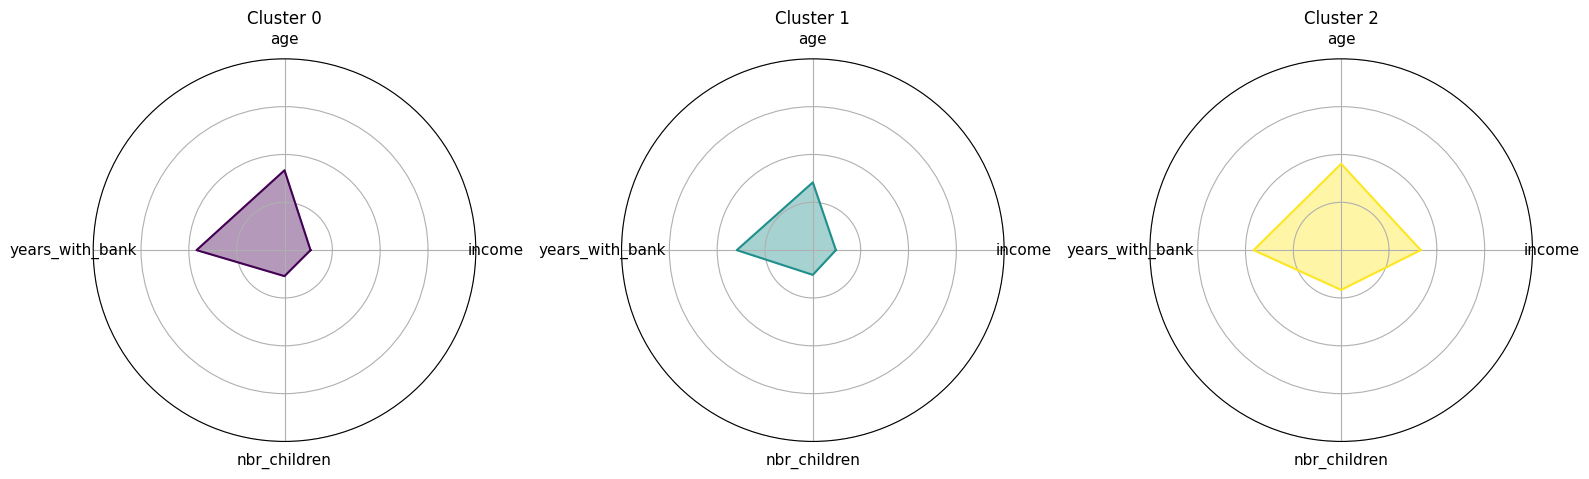

In [52]:
#Visualize demographic info of clusters

#set some colors for visualizations
viridis = ['#440154', '#21908C', '#FDE725']

# Compute the mean of each cluster for each feature
cluster_means = traits_with_labels.groupby('cluster').mean()

# Create a series of radar charts
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(16, 6), subplot_kw=dict(projection='polar'))

# Set the number of radial gridlines to 5 for each polar subplot
for ax in axs:
    ax.set_rgrids(np.linspace(0, 1, num=5))
    ax.set_ylim([0, 1])

for i, ax in enumerate(axs):
    # Calculate the angle for each variable
    angles = np.linspace(0, 2*np.pi, len(cluster_means.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Plot the normalized mean for the i-th cluster
    values = np.concatenate((cluster_means.iloc[i].values.flatten().tolist(), [cluster_means.iloc[i][0]]))
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', color = viridis[i])
    ax.fill(angles, values, alpha=0.4, color = viridis[i])
    
    # Set the title and labels
    ax.set_title(f'Cluster {i}')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(cluster_means.columns, ha='center', fontsize=11)
    ax.set_yticklabels([])
    
# Add a legend
labels = ['Feature {}'.format(i) for i in range(1, len(cluster_means.columns)+1)]

# Adjust the layout and show the plot
fig.tight_layout()
plt.show()